In [2]:
import polars as pl
from pathlib import Path

In [3]:
from datetime import datetime
import re

def find_latest_completeness_file(
    p: str = ".",
    prefix: str = "csdc_dl_completeness_",
) -> Path | None:
    """
    Find latest completeness CSV by timestamp in filename:
    csdc_dl_completeness_YYYY-MM-DD_HH-MM_*.csv
    """
    pattern = f"{prefix}*.csv"

    dir_path = Path(p)

    files = list(dir_path.glob(pattern))

    if not files:
        return None

    pat = re.compile(
        rf"{re.escape(prefix)}(\d{{4}}-\d{{2}}-\d{{2}}_\d{{2}}-\d{{2}})"
    )

    def extract_dt(p: Path) -> datetime:
        m = pat.search(p.name)
        if not m:
            raise ValueError(f"Bad filename format: {p.name}")
        return datetime.strptime(m.group(1), "%Y-%m-%d_%H-%M")

    return max(files, key=extract_dt)

In [5]:
# df = pd.read_csv("csdc_dl_completeness_2026-01-23_14-49_2000.csv")
# df = pl.read_csv("csdc_dl_completeness_2026-01-24_10-19_2000.csv")
df = pl.read_csv(find_latest_completeness_file())

df

tile,year,filename,status
str,i64,str,str
"""31UFS""",2000,"""SDC30_V003_31UFS_20000101.tif""","""complete"""
"""31UFS""",2000,"""SDC30_V003_31UFS_20000105.tif""","""complete"""
"""31UFS""",2000,"""SDC30_V003_31UFS_20000109.tif""","""complete"""
"""31UFS""",2000,"""SDC30_V003_31UFS_20000113.tif""","""complete"""
"""31UFS""",2000,"""SDC30_V003_31UFS_20000117.tif""","""complete"""
…,…,…,…
"""33UVQ""",2000,"""SDC30_V003_33UVQ_20001214.tif""","""complete"""
"""33UVQ""",2000,"""SDC30_V003_33UVQ_20001218.tif""","""complete"""
"""33UVQ""",2000,"""SDC30_V003_33UVQ_20001222.tif""","""complete"""


In [6]:
completeness_stats = df.group_by(['year', 'tile', 'status']).len().with_columns(
    (pl.col('len') / pl.sum('len').over(['year', 'tile'])).alias("pct")
)
completeness_stats

year,tile,status,len,pct
i64,str,str,u32,f64
2000,"""32UQB""","""complete""",92,1.0
2000,"""31UGR""","""complete""",92,1.0
2000,"""33UUU""","""complete""",92,1.0
2000,"""33UVV""","""complete""",92,1.0
2000,"""33UVU""","""missing""",10,0.108696
…,…,…,…,…
2000,"""32UPF""","""missing""",2,0.021739
2000,"""33UUP""","""complete""",92,1.0
2000,"""32UPC""","""complete""",77,0.836957


In [7]:
comp = completeness_stats.filter(
    (pl.col('status') == "complete") 
)

comp['pct'].sum() / comp['pct'].len()

0.9873458792991563

In [8]:
import seaborn as sns

sns.set_theme(style="whitegrid", font="sans-serif", rc={'figure.figsize':(25,10)})


In [9]:
incomplete_tiles = completeness_stats.filter(
    (pl.col('status') == "complete") & (pl.col('pct') != 1.0)
)["tile"].unique()
incomplete_tiles

tile
str
"""33UVU"""
"""32UMB"""
"""32UPF"""
"""33UVS"""
"""32UNU"""
"""32UPC"""


<Axes: xlabel='tile', ylabel='pct'>

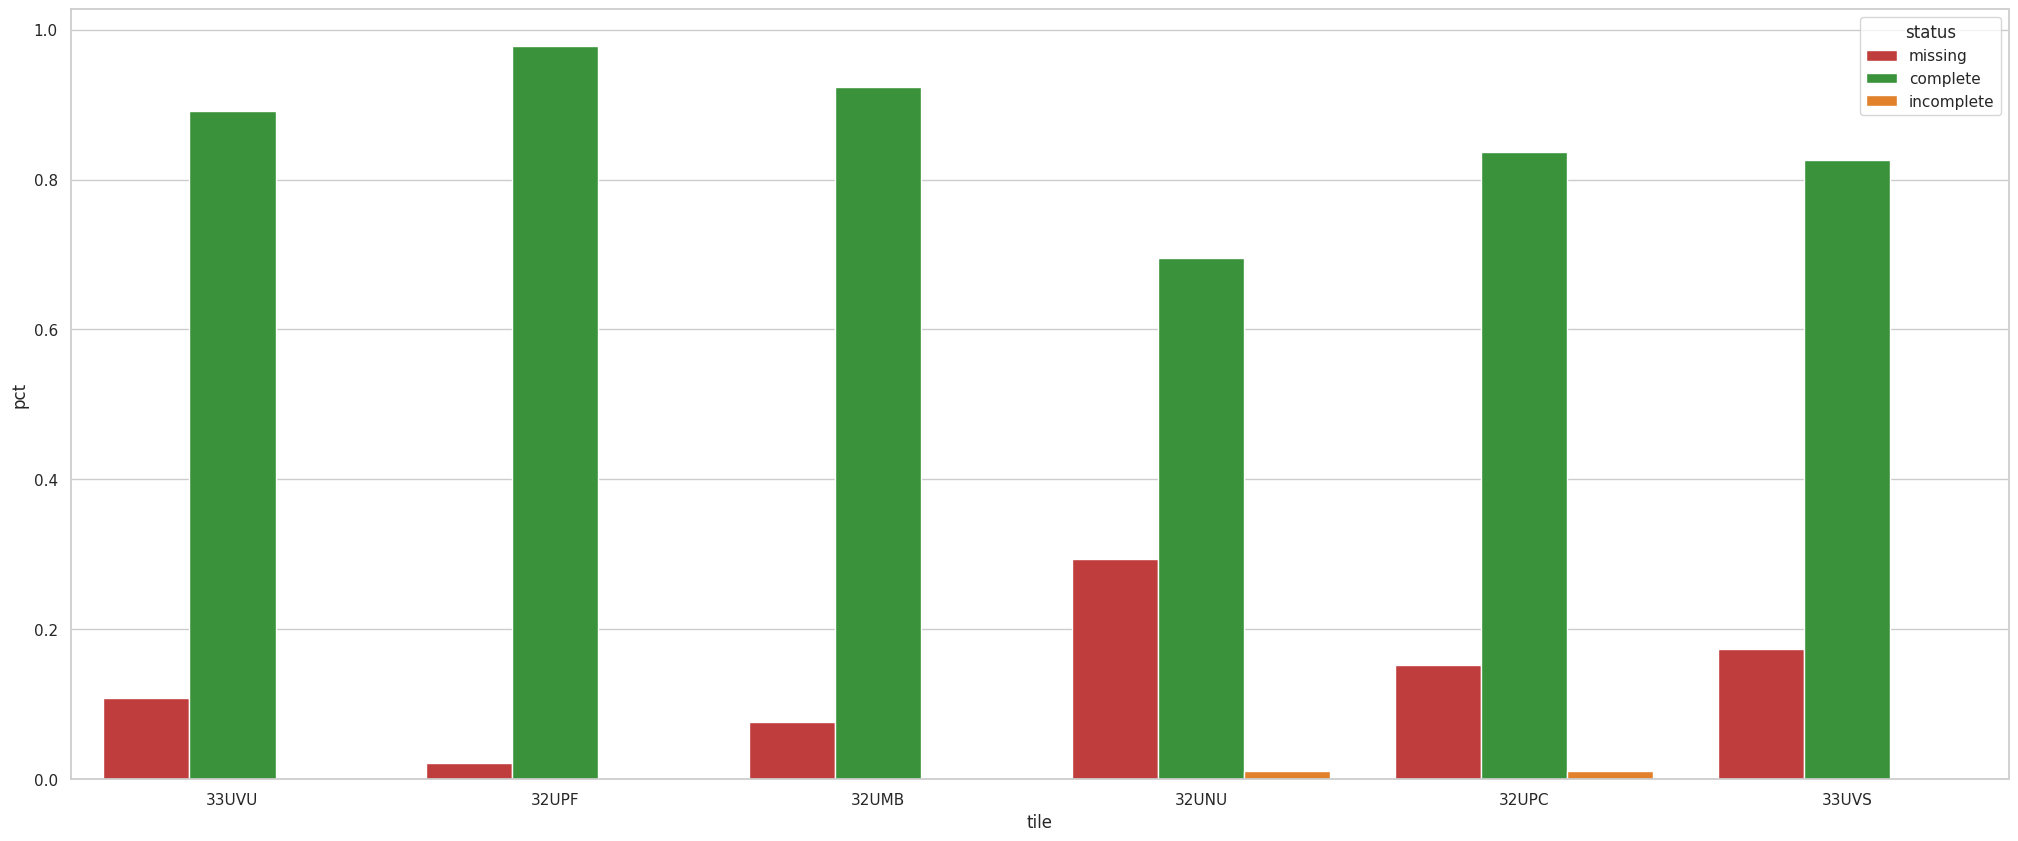

In [10]:
sns.barplot(data=completeness_stats.filter(pl.col("tile").is_in(incomplete_tiles.implode())), x='tile', y='pct', hue='status', palette=dict(complete="#2ca02c", missing="#d62728", incomplete="#ff7f0e"))

In [51]:
cols = ["sign_file_time", "download_file_time"]

acc_stats_ds = pl.read_csv("getsigned_dl_stats_5_concurrent.csv", new_columns=cols).with_columns(
    [pl.col(c).str.strip_chars().cast(pl.Float64) for c in cols]
)
acc_stats_ds

sign_file_time,download_file_time
f64,f64
1.52,69.09
1.46,22.76
1.47,23.51
1.45,24.15
1.47,20.71
…,…
1.49,21.82
1.45,17.37
1.56,20.11


In [71]:
acc_stats_long = acc_stats_ds.with_row_index('index').unpivot(
    on=["sign_file_time", "download_file_time"],
    index='index',
    variable_name='request_category',
    value_name='time in s'
).with_columns(
    pl.col('request_category').str.split("_").list.get(0)
)

<Axes: xlabel='request_category', ylabel='time in s'>

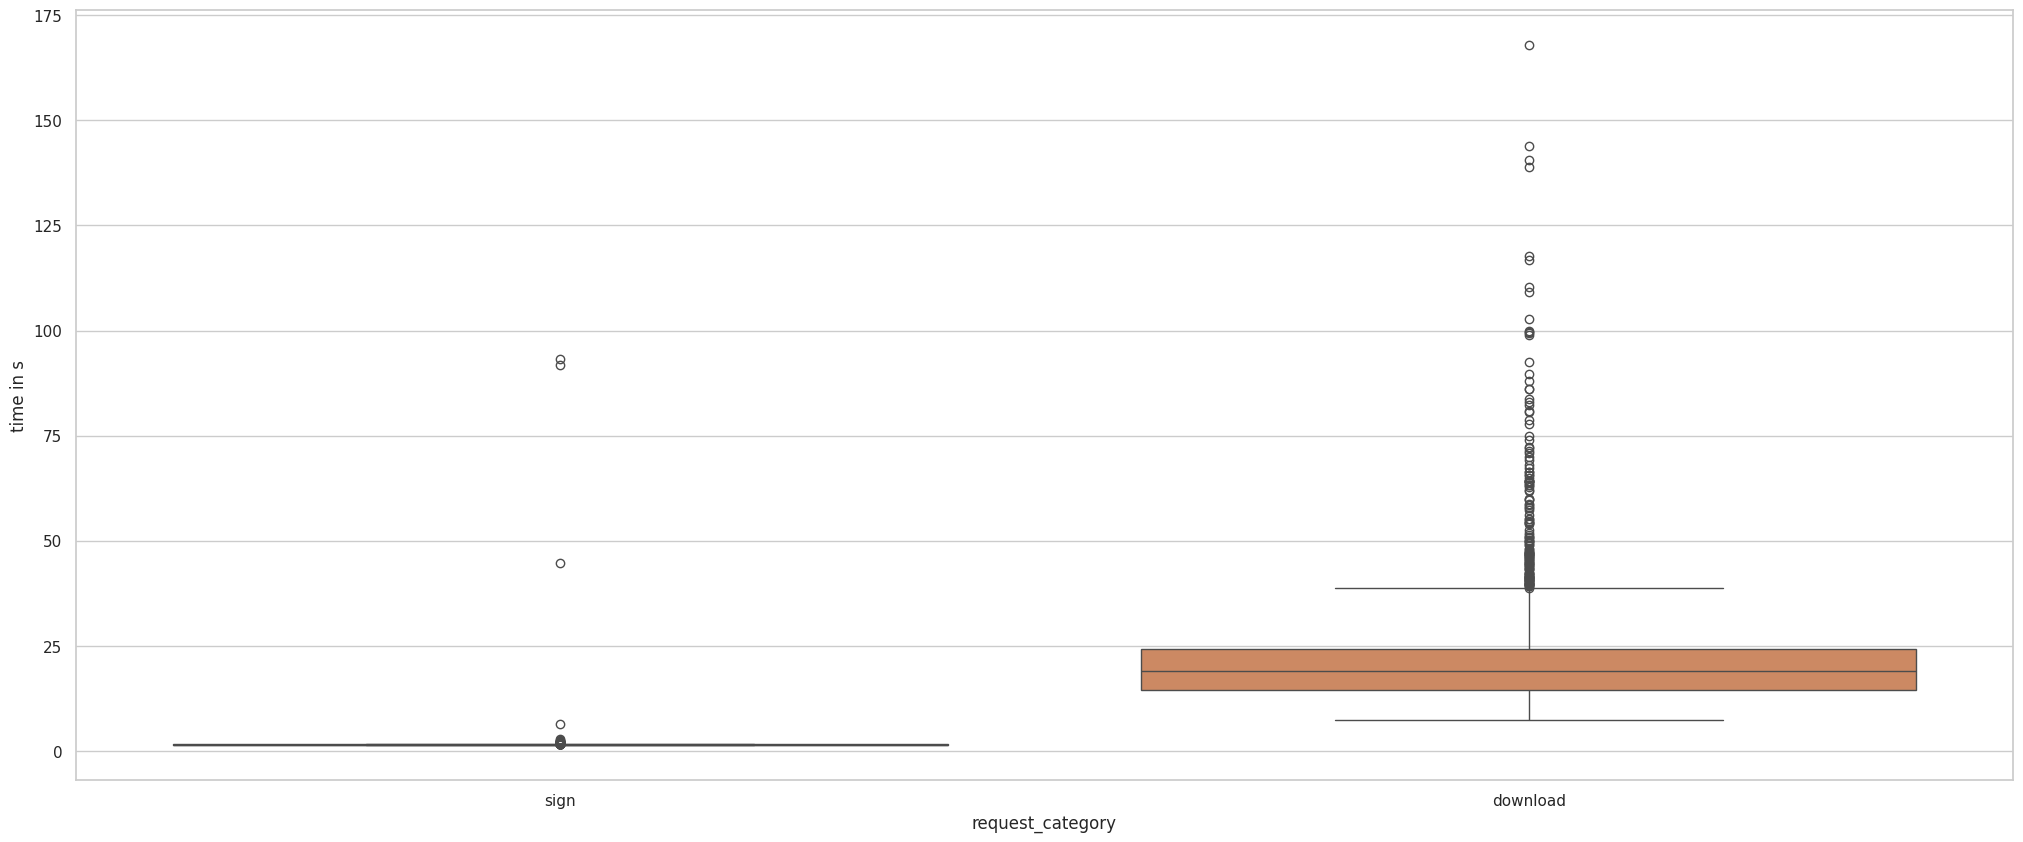

In [73]:
sns.boxplot(data=acc_stats_long, x="request_category", y="time in s", hue="request_category")

<Axes: xlabel='index', ylabel='time in s'>

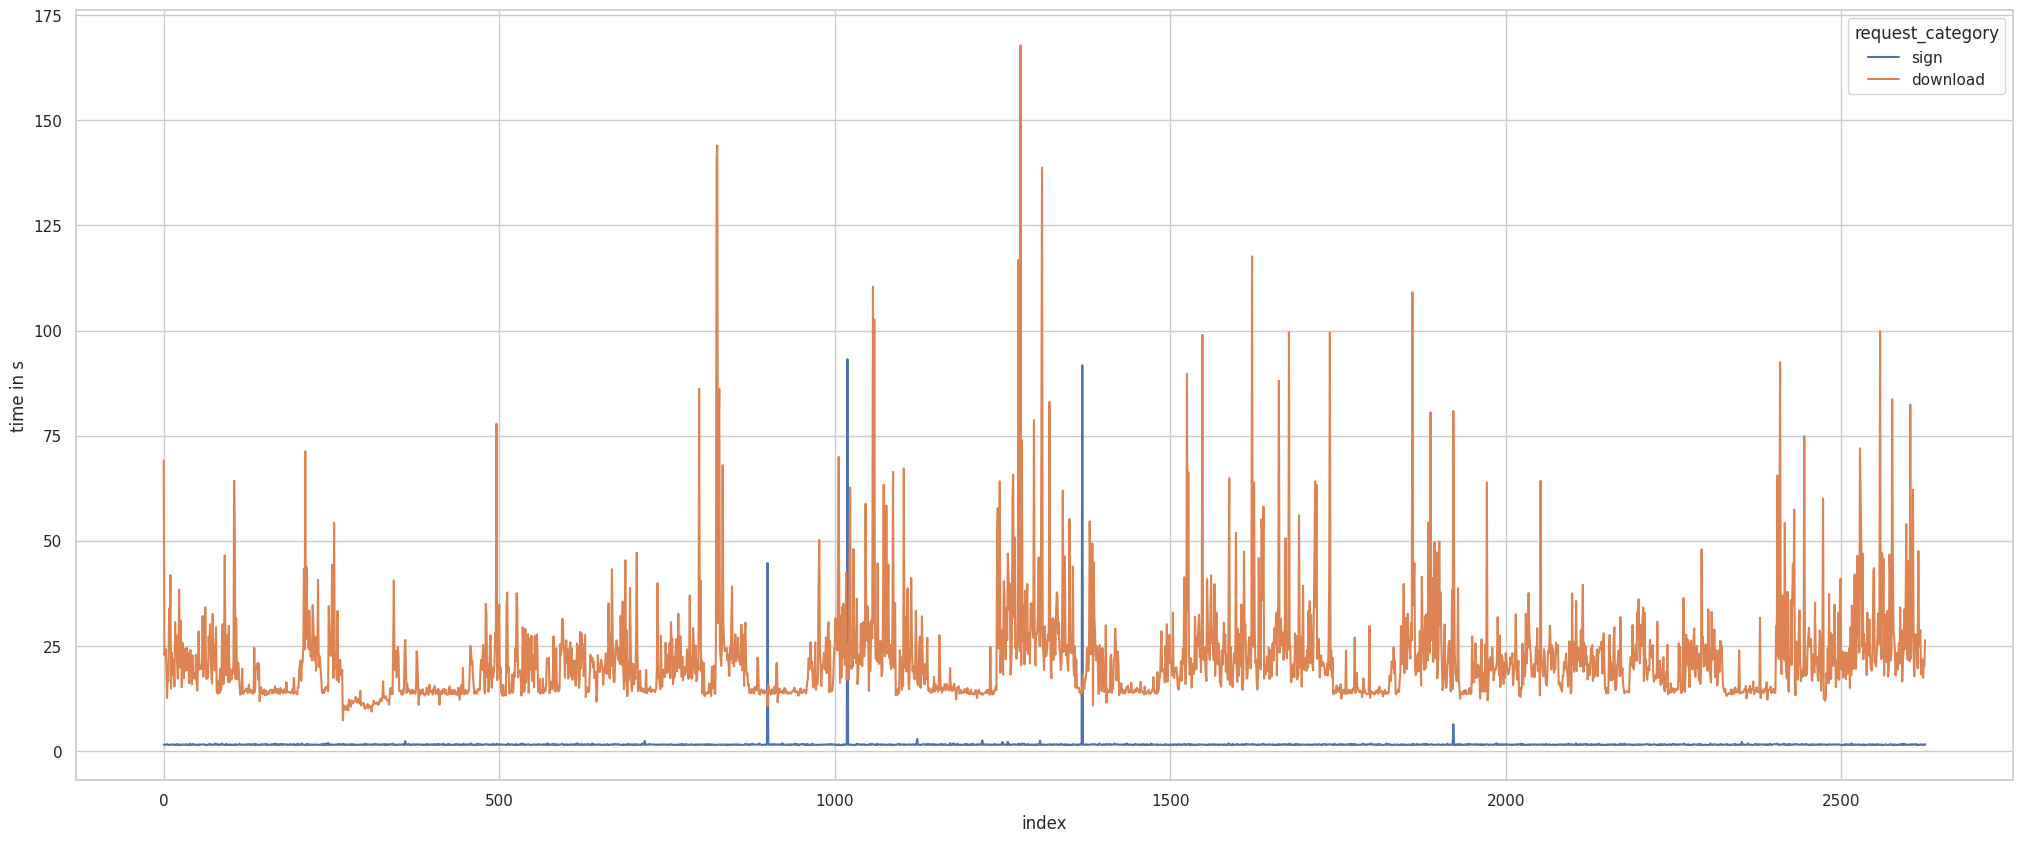

In [74]:
sns.lineplot(data=acc_stats_long, x='index', y="time in s", hue="request_category")